In [1]:
# from obspy modules import functions
from obspy import read, UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.stream import Stream

# Part one: load and select data

In [2]:
# read the downloaded waveforms into obspy stream object
st = read('./2019-07-06-mw71-central-california-2.miniseed')

In [3]:
# select traces ehose location is '10'
st_10 = st.select(location='10')

In [4]:
# from the IRIS webpage about this instrument
# channel 'BH1' azimuth and dip are 0 and 0
# channel 'BH2' azimuth and dip are 90 and 0
# thus, we rename 'BH1' into 'BHN'
# and rename 'BH2' into 'BHE'
# this is useful for waveform rotation
for tr in st_10:
    if tr.stats.channel == 'BH1':
        tr.stats.channel = 'BHN'
    if tr.stats.channel == 'BH2':
        tr.stats.channel = 'BHE'

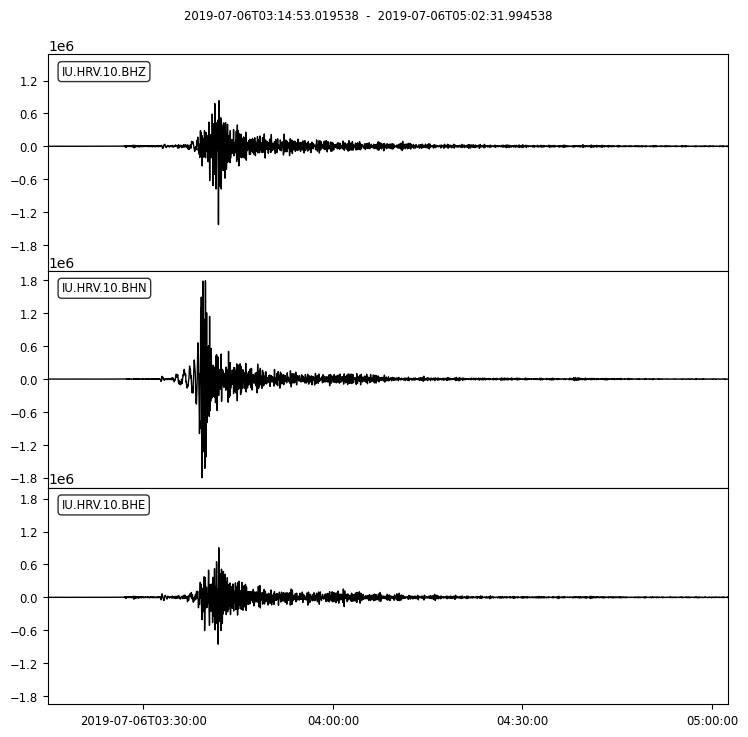

In [5]:
# quick check
st_10.plot();

# Part two: rotate data from locations

In [6]:
# event info
event_otime = UTCDateTime('2019-07-06 03:19:53')
event_longitude = -117.599333
event_latitude = 35.7695
event_depth = 8 # kilometer
event_magnitude = 7.1

In [7]:
# station info
station_longitude = -71.5583
station_latitude = 42.5064
station_elevation = 200.0 # meter
station_depth = 0.0

In [8]:
# compute epicentral distance, azimuth, and back azimuth
# for this earthquake-station pair
dist_in_m, az, baz = gps2dist_azimuth(event_latitude, event_longitude, station_latitude, station_longitude)
print('epicentral distance is: %.2f m'%dist_in_m)
print('azimuth is: %.2f'%az)
print('back azimuth is: %.2f'%baz)

epicentral distance is: 3999969.28 m
azimuth is: 64.89
back azimuth is: 274.97


In [9]:
# use the rotate function to rotate waveforms
# from ZNE coordinate system to ZRT coordinate system
st_10.rotate('NE->RT', back_azimuth=baz)

3 Trace(s) in Stream:
IU.HRV.10.BHR | 2019-07-06T03:14:53.019538Z - 2019-07-06T05:02:31.994538Z | 40.0 Hz, 258360 samples
IU.HRV.10.BHT | 2019-07-06T03:14:53.019538Z - 2019-07-06T05:02:31.994538Z | 40.0 Hz, 258360 samples
IU.HRV.10.BHZ | 2019-07-06T03:14:53.019538Z - 2019-07-06T05:02:31.994538Z | 40.0 Hz, 258360 samples

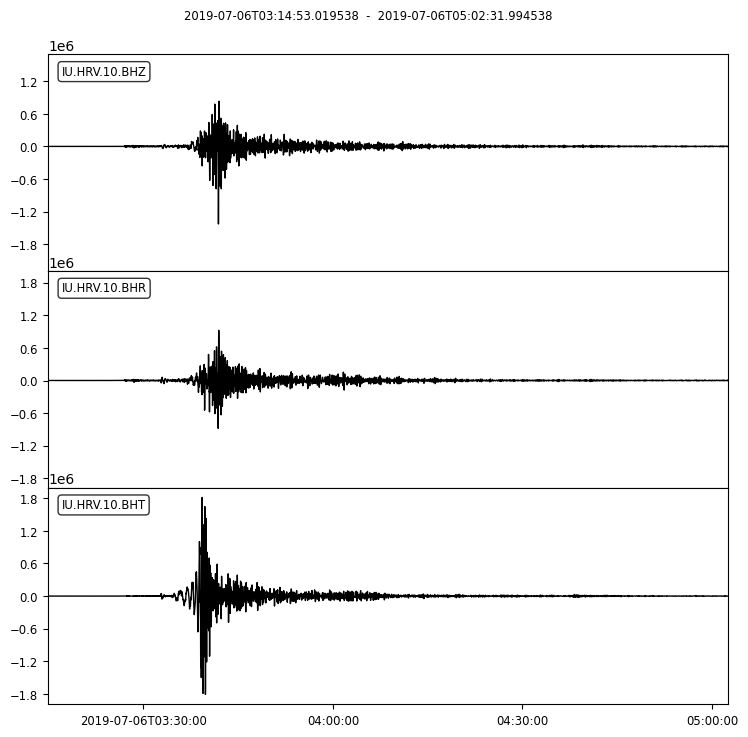

In [10]:
# quick check
# Note that Love wave in the transverse component
# Rayleigh wave in the radial and vertical components
st_10.plot();

# Part three: check the dispersion of Love wave

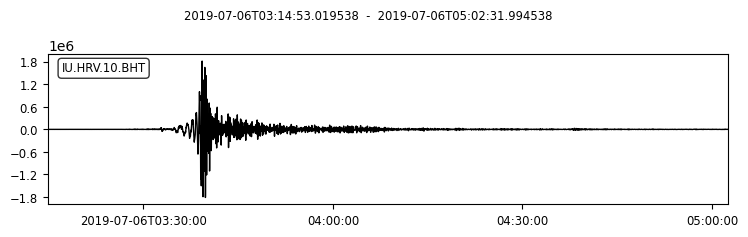

In [14]:
# now only select transverse component for further analysis
tr = st_10.select(component='T')[0]
tr.plot();

In [15]:
# The dispersion means that
# velocities at a number of periods are different
# since distance won't change
# higher velocity -> smaller travel time
# lower velocity  -> larger travel time

In [16]:
# from IRIS webpage, we know that
# the flat response of this instrument is
# 50s/0.02 Hz -> 20 Hz

In [17]:
# now choose a set of periods
# and their units are in second
period_bands = [[10, 20], 
                [20, 30], 
                [30, 40], 
                [40, 50]]

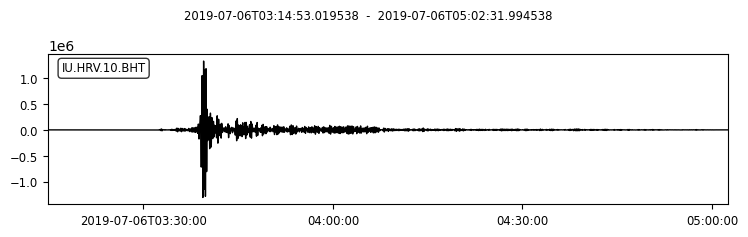

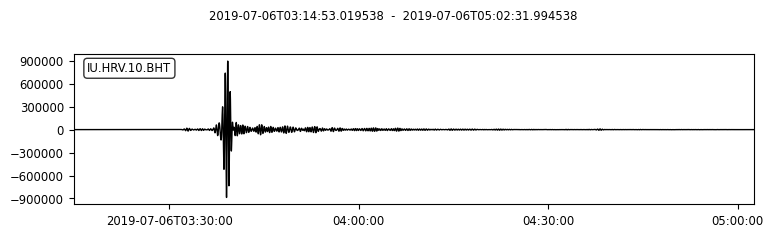

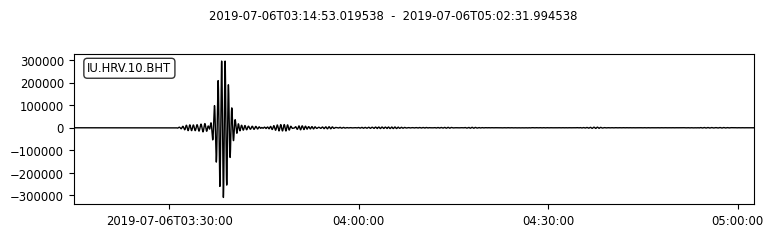

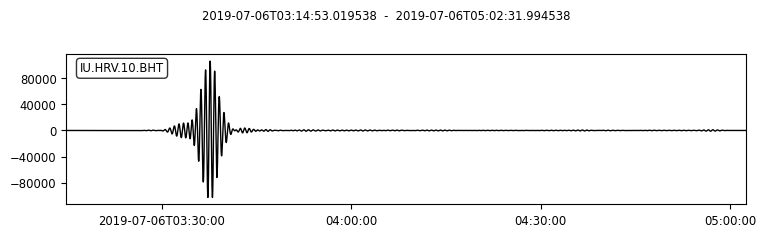

In [18]:
# loop for each period band
for period_band in period_bands:
    # convert period into frequency
    # which is the inverse of period
    freq_high, freq_low = 1./period_band[0], 1./period_band[1]
    # any processing directly on trace/stream would be irreversible
    # so use copy function to duplicate a trace object each time
    # and then only process the temporary trace object
    tr_copy = tr.copy()
    # remove mean, linear trend, and taper at both ends
    tr_copy.detrend('demean').detrend('linear').taper(0.05)
    # apply bandpass filter to the raw waveform
    tr_copy.filter('bandpass', freqmin=freq_low, freqmax=freq_high, corners=2, zerophase=True)
    # quick plot
    tr_copy.plot();

In [19]:
# now we want all traces share the same x-axis
# how to do? if without using the Matplotlib module
# very easy

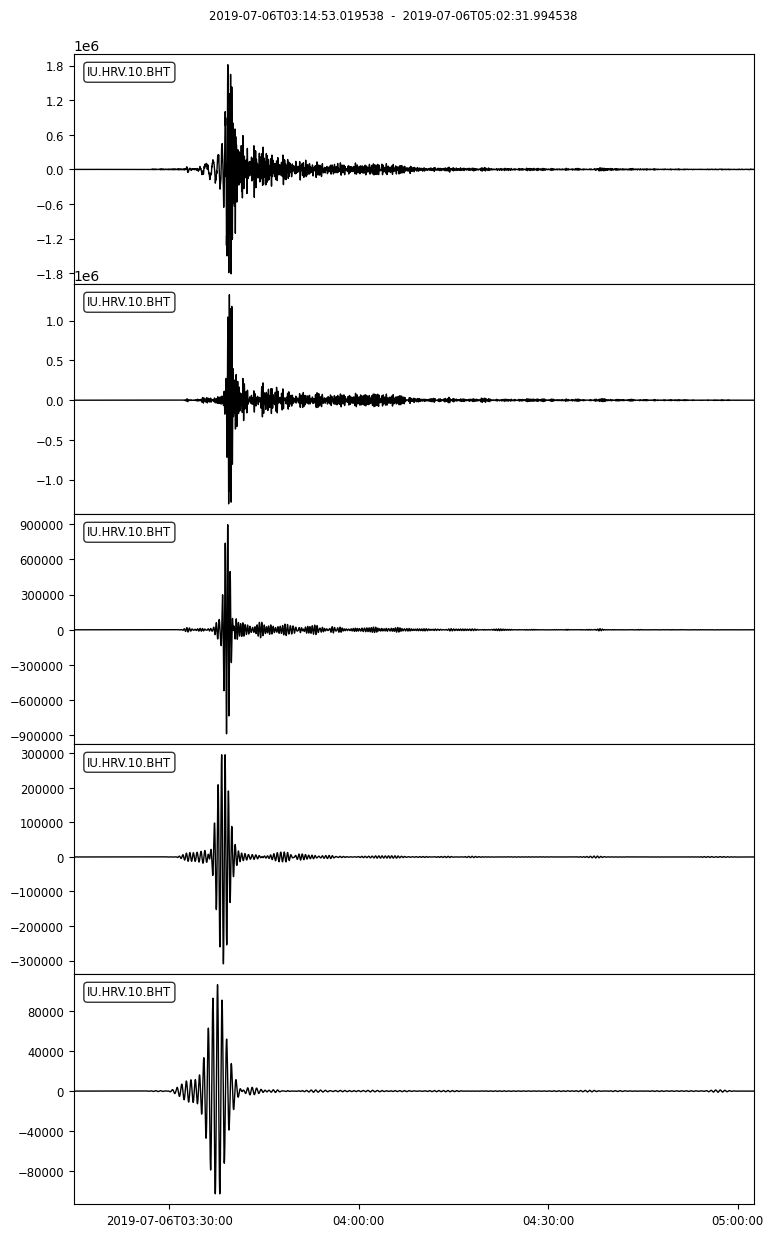

In [20]:
# first create an empty stream
st_BHT = Stream()
# the first trace is raw waveform without filtering
st_BHT += tr
# similar to the above loop except the last plot line is changed
for period_band in period_bands:
    freq_high, freq_low = 1./period_band[0], 1./period_band[1]
    tr_copy = tr.copy()
    tr_copy.detrend('demean').detrend('linear').taper(0.05)
    tr_copy.filter('bandpass', freqmin=freq_low, freqmax=freq_high, corners=2, zerophase=True)
    st_BHT += tr_copy
# quick plot with some newly arguments specified
st_BHT.plot(equal_scale=False, automerge=False);

In [21]:
# not very clear? 
# then let's zoom-in

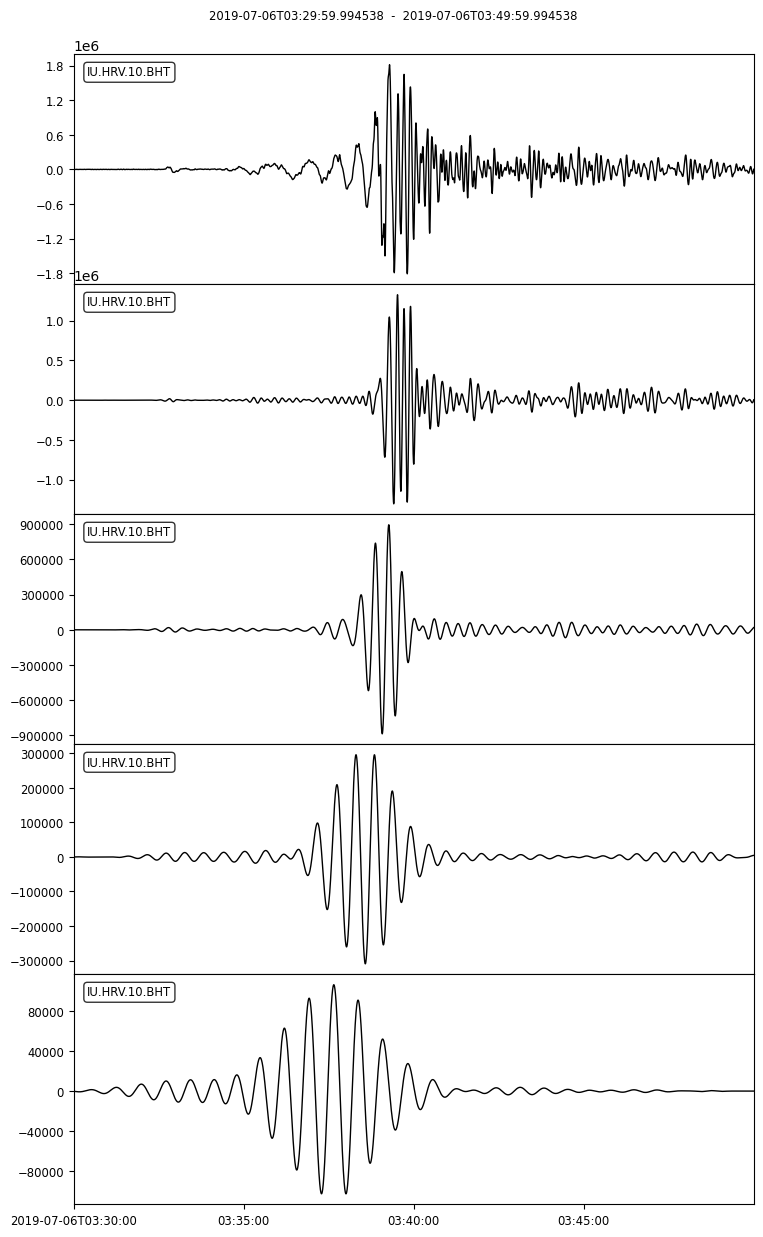

In [22]:
st_BHT.trim(starttime=UTCDateTime('2019-07-06 03:30:00'), endtime=UTCDateTime('2019-07-06 03:50:00'))
st_BHT.plot(equal_scale=False, automerge=False);

# Assignment: Search for another earthquake and request the seismograms at one station. Then perform phase delay and dispersion analysis. Scripts, figures, and detailed descriptions are needed. 